### Quantum GANs
In this script, we will try to explore quantum GANs to generate hand-written digits of zero.
</br>
However, This method unsuccessfully reproduces high-dimensional.


</br>

#### Reference
* [github](https://github.com/qiskit-community/qiskit-machine-learning)

In [ ]:
! pip install watermark==2.4.2
! pip install pylatexenc==2.10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=f3deaf7b370a204254db6d8b135b3184cb52b7a490943e99b0885182b19e4fc6
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [ ]:
! pip install qiskit[machine-learning]==0.44.0
! pip install qiskit[finance]==0.44.0

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 11.9 MB/s eta 0:00:00
  Created wheel for qiskit: filename=qiskit-0.44.0-py3-non

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Qiskit
from qiskit_machine_learning.algorithms import QGAN

from qiskit import BasicAer, ClassicalRegister, QuantumCircuit, execute
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import random_statevector
from qiskit_finance.circuit.library.probability_distributions import UniformDistribution, NormalDistribution
from qiskit.utils import QuantumInstance # qiskit >0.25

from qiskit_machine_learning.algorithms.distribution_learners import NumPyDiscriminator, PyTorchDiscriminator  # qiskit >0.25
from qiskit_machine_learning.datasets.dataset_helper import discretize_and_truncate # qiskit >0.25


# pytorch dataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch

In [ ]:
# @title dataset

#@title dataset

class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):

        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

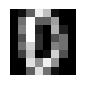

In [ ]:
image_size = 8  # Height / width of the square images
batch_size = 1
label = 0 # default value is 0



transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="https://datahub.io/machine-learning/optdigits/r/optdigits.csv", label=label, transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

image_size = 8  # Height / width of the square images

plt.figure(figsize=(8,2))

for i in range(1):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

In [ ]:
get_shape_ = dataset[0][0].reshape(image_size,image_size).shape
get_shape_

torch.Size([8, 8])

In [ ]:
# from qiskit_machine_learning.algorithms import QGAN

import math

bounds = np.array([0.0, 1.0])
num_qubits = [6]

batch_size = 6
num_epochs = 150

# if dataset have high-dimensional, needs reshape(-1) or flatten
qgan = QGAN(data=dataset[0][0].numpy().reshape(-1), # k_dimension
            bounds=bounds, # k_min/max
            num_qubits=num_qubits, # 2**n
            batch_size=batch_size,
            num_epochs=num_epochs,
            )

In [ ]:
display(bounds)
display(num_qubits)

array([0., 1.])

[6]

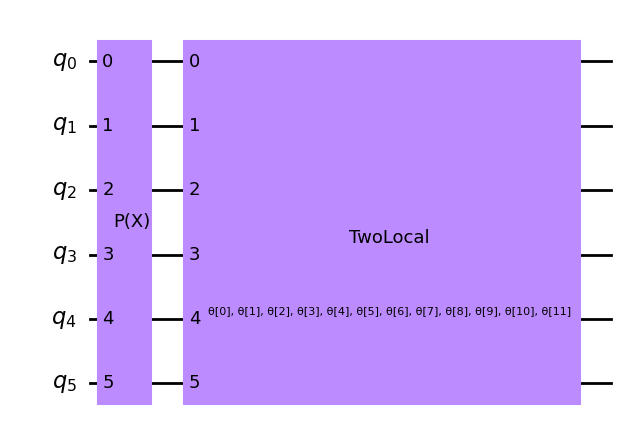

In [ ]:
# @title create of quantum circuits

# from qiskit import BasicAer, ClassicalRegister, QuantumCircuit, execute
# from qiskit.circuit.library import TwoLocal
# from qiskit.quantum_info import random_statevector
# from qiskit_finance.circuit.library.probability_distributions import UniformDistribution, NormalDistribution  # qiskit 0.25未満

# Initial circuit setting
init_dist = UniformDistribution(sum(num_qubits))

# variational quantum circuit setting
var_form = TwoLocal(int(np.sum(num_qubits)), "ry", "cz", reps=1)

g_circuit = var_form.compose(init_dist, front=True)

g_circuit.draw("mpl")

--------
### Training

In [ ]:
# from qiskit.utils import QuantumInstance
# from qiskit_machine_learning.algorithms.distribution_learners import NumPyDiscriminator, PyTorchDiscriminator


init_params = np.full([1,2**num_qubits[0]], 0).tolist()[0]

qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)

# The parameters have an order issue that following is a temp. workaround
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)

discriminator = PyTorchDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(
    backend=BasicAer.get_backend("statevector_simulator")
)


# QGAN error: https://github.com/qiskit-community/qiskit-machine-learning/issues/336
### Max retry limit reached. Failed to submit the qobj correctly
result = qgan.run(quantum_instance)

# estimate
print("Training results:")
print("loss_d :", result["loss_d"])
print("loss_g :", result["loss_d"])
print("rel_entr", result["rel_entr"])

<ipython-input-217-5cb4bf829d8a>:21: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(


Training results:
loss_d : 0.6705
loss_g : 0.6705
rel_entr 13.0699


In [ ]:
# @title estimate

samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)

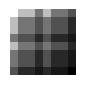

In [ ]:
image_size = 8  # Height / width of the square images

plt.figure(figsize=(8,2))

for i in range(1):
    image = np.array(prob_g).reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

plt.show()

In [ ]:
# @title prob_data

np.array(prob_g).reshape(image_size,image_size)

array([[0.03492348, 0.02751641, 0.02749927, 0.01908356, 0.02749927,
        0.01906822, 0.01905023, 0.01515616],
       [0.02747042, 0.0190816 , 0.0190636 , 0.01514031, 0.01904828,
        0.01514029, 0.01513085, 0.01040853],
       [0.02745172, 0.01909155, 0.01907354, 0.01513004, 0.01905821,
        0.01513003, 0.01512059, 0.01041398],
       [0.01907157, 0.01511419, 0.01510477, 0.01042132, 0.01510475,
        0.01041293, 0.0104031 , 0.00832485],
       [0.02743394, 0.01910257, 0.01908456, 0.01512028, 0.01906923,
        0.01512027, 0.01511084, 0.01042003],
       [0.01908258, 0.01510444, 0.01509502, 0.01042737, 0.01509501,
        0.01041897, 0.01040914, 0.0083195 ],
       [0.01909251, 0.01509418, 0.01508477, 0.01043282, 0.01508476,
        0.01042442, 0.01041458, 0.00831387],
       [0.01506896, 0.01043176, 0.01042191, 0.00830519, 0.01041353,
        0.00830518, 0.00829999, 0.00569021]])

In [ ]:
# @title original_data

dataset[0][0].reshape(image_size,image_size)

tensor([[0.0000, 0.0625, 0.3750, 0.9375, 0.7500, 0.0625, 0.0000, 0.0000],
        [0.0000, 0.4375, 1.0000, 0.3750, 0.3750, 0.6250, 0.0000, 0.0000],
        [0.0000, 0.5000, 1.0000, 0.1250, 0.0000, 0.6875, 0.1250, 0.0000],
        [0.0000, 0.3125, 1.0000, 0.1875, 0.0000, 0.3125, 0.4375, 0.0000],
        [0.0000, 0.4375, 0.8125, 0.1875, 0.0000, 0.5000, 0.4375, 0.0000],
        [0.0000, 0.2500, 0.7500, 0.0000, 0.0625, 0.8125, 0.3125, 0.0000],
        [0.0000, 0.0000, 0.8750, 0.5625, 0.9375, 0.5625, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3750, 0.8750, 0.4375, 0.0625, 0.0000, 0.0000]])

In [ ]:
# @title version

%load_ext watermark
%watermark

Last updated: 2023-08-21T10:10:34.229916+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.109+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

